- разбить в фотки 300 на 300

In [26]:
import pandas as pd
import os
import cv2
import json
from PIL import Image, ImageDraw
import numpy as np
from tqdm.notebook import tqdm

import math

import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

In [27]:
df = pd.read_csv('data/walrus_count.csv', index_col=0)

In [28]:
BASE_DIR = 'data/min_of_nature/'
IMAGES_DIR = os.path.join(BASE_DIR, 'images')
MARKUPS_DIR = os.path.join(BASE_DIR, 'markup')

In [29]:
def mask_from_coco(img, polygons):
    img = Image.new('L', (img.shape[1], img.shape[0]), 0)
    for polygon in polygons:
        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)  
    mask = np.array(img)
    
    return mask

In [30]:
def read_coco(image_name):
    image_name = image_name.split('.')[0] + '.json'
    
    with open(os.path.join(MARKUPS_DIR, image_name), 'r') as f:
        data = json.load(f)
        
    return data

In [31]:
def read_img(image_name):
    image_name = image_name.split('.')[0] + '.JPG'
    
    img = cv2.imread(
        os.path.join(
            IMAGES_DIR, 
            image_name
        ),
        cv2.IMREAD_GRAYSCALE
    )

    return img

In [32]:
def show_image(img, title=''):
    plt.figure(figsize=(16, 9))
    plt.title(title)
    plt.imshow(img)
    plt.show()

In [33]:
from sklearn.cluster import DBSCAN, KMeans

In [34]:
DEFAULT_SIZE = (1090, 920)

In [137]:
def get_image_points(image_name):
    img = read_img(image_name)
    coco = read_coco(image_name)
    mask = mask_from_coco(img, [c['segmentation_poly'][0] for c in coco])
    
    img = cv2.resize(img, DEFAULT_SIZE)
    mask = cv2.resize(mask, DEFAULT_SIZE)
    
    points = np.array([(i, j) for i in range(mask.shape[0]) for j in range(mask.shape[1]) if mask[i, j] != 0])
    
    return points

In [153]:
def _get_walrus_count(points):
    dbscan = DBSCAN(eps=1)
    dbscan.fit(points)
    
    counts = np.unique(dbscan.labels_, return_counts=True)[1]
    m_count = np.median(counts)
    count = math.ceil(len(points) / m_count)
    
    return count

In [139]:
import faiss

In [140]:
def get_centroids(points, m_count):
    niter = 3
    verbose = False
    d = points.shape[1]
    kmeans = faiss.Kmeans(d, m_count, niter=niter, verbose=verbose, gpu=False)
    kmeans.train(points.astype('float32'))
    
    return kmeans.centroids

In [141]:
def walrus_points(image_name):
    img = cv2.imread(
        os.path.join(
            IMAGES_DIR, 
            image_name
        ),
    )
    
    points = get_image_points(image_name)
    m_count = _get_walrus_count(points)
    
    cluster_centers = get_centroids(points, m_count)
    
    for center in cluster_centers:
        center = list(map(int, center[::-1]))
        center[0] = int(center[0] / DEFAULT_SIZE[0] * img.shape[1])
        center[1] = int(center[1] / DEFAULT_SIZE[1] * img.shape[0])

        img = cv2.circle(img, center, radius=20, color=(0, 0, 255), thickness=-1)

    return img, m_count

In [119]:
def get_walrus_count(image_name):
    img = cv2.imread(
        os.path.join(
            IMAGES_DIR, 
            image_name
        ),
    )
    
    points = get_image_points(image_name)
    m_count = _get_walrus_count(points)
    
    return m_count

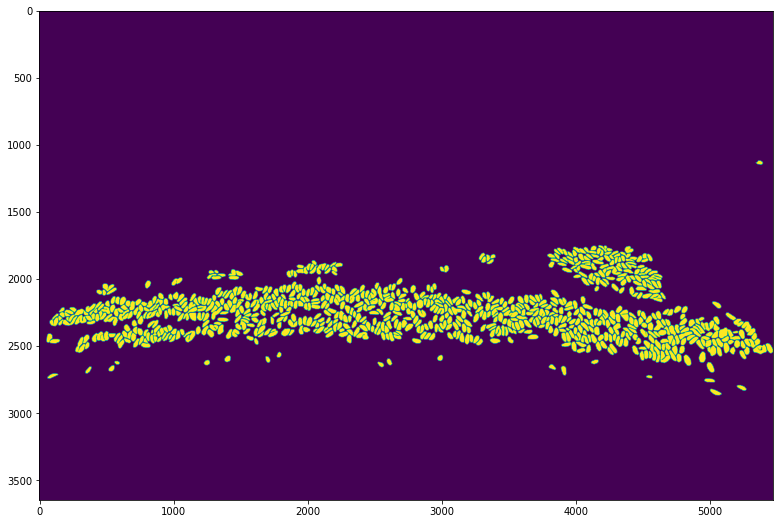

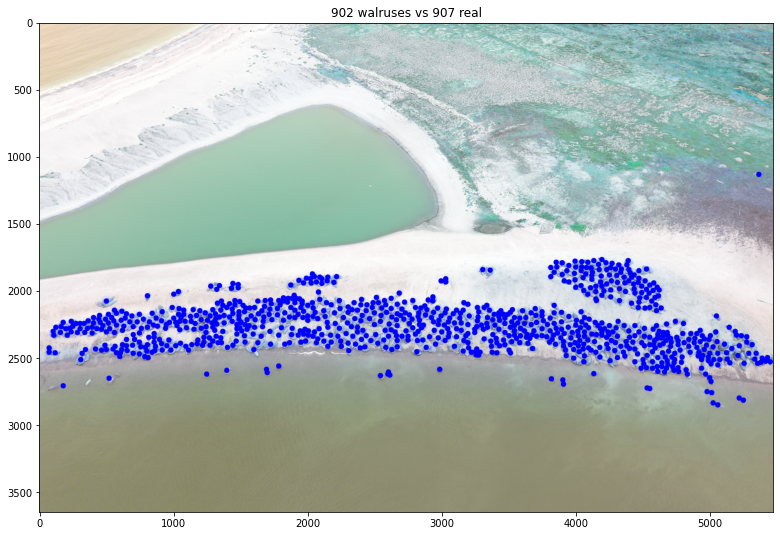

CPU times: user 9.23 s, sys: 645 ms, total: 9.88 s
Wall time: 7.28 s


In [110]:
%%time

image_name = 'DJI_0079.JPG'  # 905

img, m_count = walrus_points(image_name)

coco = read_coco(image_name)
mask = mask_from_coco(img, [c['segmentation_poly'][0] for c in coco])    

show_image(mask)
show_image(img, title=str(m_count) + ' walruses vs ' + str(df[df.image_name == image_name].iloc[0]['count']) + ' real')

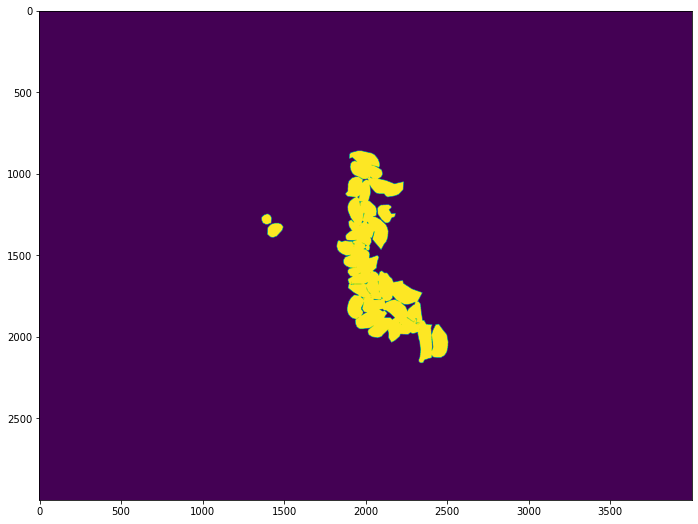

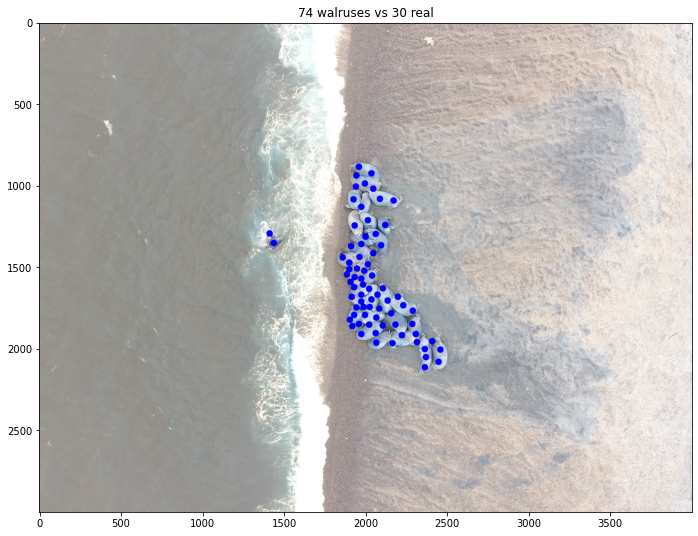

CPU times: user 5.98 s, sys: 577 ms, total: 6.56 s
Wall time: 4.9 s


In [124]:
%%time

image_name = 'DJI_0003 (5).JPG'  # 22

img, m_count = walrus_points(image_name)

coco = read_coco(image_name)
mask = mask_from_coco(img, [c['segmentation_poly'][0] for c in coco])    

show_image(mask)
show_image(img, title=str(m_count) + ' walruses vs ' + str(df[df.image_name == image_name].iloc[0]['count']) + ' real')

In [156]:
import datetime

data = []
start_time = datetime.datetime.now()

for name in tqdm(df.image_name):
    points = get_image_points(name)
    dbscan = DBSCAN(eps=1)
    dbscan.fit(points)
    
    counts = np.unique(dbscan.labels_, return_counts=True)[1]
    m_count = np.median(counts)
    count = math.ceil(len(points) / m_count)
    
    data.append((data, counts, count, (datetime.datetime.now() - start_time).total_seconds()))

  0%|          | 0/124 [00:00<?, ?it/s]

In [160]:
counts = np.array(data)[:, 2]

/var/folders/yb/ysqh2wxs6v1_4q_92fnn6q380000gn/T/ipykernel_92082/1386402914.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  counts = np.array(data)[:, 2]


In [163]:
df['predicted_counts'] = counts

In [174]:
mae = np.abs(df.predicted_counts - df['count'])

In [184]:
z = []

for m, b in zip(mae, df['count']):
    z.append(m / b)

z = np.array(z)

In [193]:
for i in reversed(range(1, len(speed))):
    speed[i] = speed[i] - speed[i - 1]

In [197]:
plt.rc('font', size=16)

<AxesSubplot:xlabel='Скорость работы, с', ylabel='Количество'>

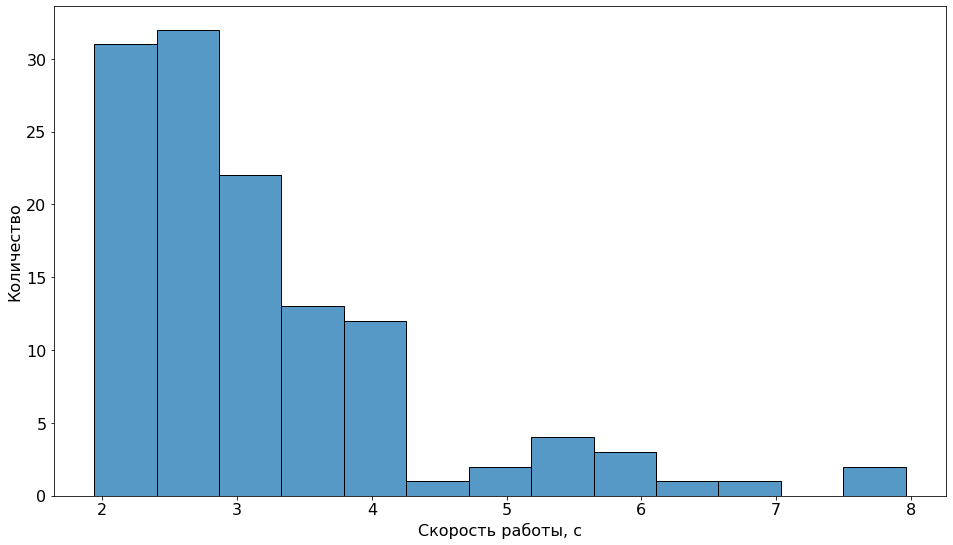

In [198]:
plt.figure(figsize=(16, 9))
plt.xlabel('Скорость работы, с')
plt.ylabel('Количество')
sns.histplot(speed)

In [188]:
speed = np.array(data)[:, 3]

/var/folders/yb/ysqh2wxs6v1_4q_92fnn6q380000gn/T/ipykernel_92082/3687702963.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  speed = np.array(data)[:, 3]


In [ ]:
sns.

In [189]:
speed

array([1.99845, 3.980631, 5.919591, 8.046216, 10.531137, 13.064946,
       15.427233, 17.862609, 20.21037, 22.414046, 24.755493, 27.086721,
       29.504969, 31.947119, 34.369146, 36.811396, 38.789456, 41.159839,
       43.63767, 46.001633, 48.391422, 50.709396, 52.788651, 54.90412,
       57.520877, 61.161829, 63.497952, 65.911112, 68.239301, 70.334368,
       73.117898, 75.320562, 77.469196, 79.601945, 83.294701, 86.118184,
       88.884279, 90.998357, 93.23869, 95.604109, 97.778766, 100.127785,
       102.5466, 105.000122, 107.493, 109.872427, 112.23859, 115.124451,
       117.177828, 121.373241, 125.493741, 129.076327, 131.581201,
       135.620912, 138.961064, 141.558669, 143.787411, 148.115052,
       151.372282, 154.193606, 161.74426, 167.36074, 170.870559,
       174.687712, 182.650075, 186.564796, 189.709282, 195.056128,
       200.75158, 206.564792, 213.348376, 216.842007, 222.681896,
       227.544705, 230.60967, 234.20163, 237.381303, 241.132624,
       244.253153, 248.1767

In [186]:
np.median(z)

0.10422860216880432